# MIMIC-IV TBI data extraction & exploration

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

## TBI patients (>= 18 yrs) 

#### ICDs:
ICD10CM: S02*, S04*, S06*, S07*, S09*, T02, T04, T06

ICD9CM: 800*, 801*, 803*, 804*, 850.1 – 850.5, 850.9, 851*, 852*, 853*, 854*, 959.01

translates to regex: r"^(S0[24679]|T0[246]|80[0134]|850[1-59]|85[1-4]|95901$)"

In [2]:
d_icd_diag = pd.read_csv("./mimic-iv-1.0/hosp/d_icd_diagnoses.csv.gz", compression="gzip")
diagnoses_icd = pd.read_csv("./mimic-iv-1.0/hosp/diagnoses_icd.csv.gz", compression="gzip")
icu_stays = pd.read_csv("./mimic-iv-1.0/icu/icustays.csv.gz", compression="gzip")
icd_codes = r"^(S0[24679]|T0[246]|80[0-4]|850[1-59]|85[1-4]|95901$)"
admissions = pd.read_csv("./mimic-iv-1.0/core/admissions.csv.gz", compression="gzip")
patients = pd.read_csv("./mimic-iv-1.0/core/patients.csv.gz", compression="gzip")

In [3]:
def offset_age(row):
    # Returns patient age at the time of each admission
    admit = int(row["admittime"][:4])
    return int(row["anchor_age"]) + admit - int(row["anchor_year"])

pat_adm = pd.merge(patients, admissions, on="subject_id")
pat_adm["age_admission"] = pat_adm.apply(offset_age, axis=1)
pat_features = pat_adm[pat_adm["age_admission"] >= 18][["subject_id", "hadm_id", "gender", "age_admission", "hospital_expire_flag"]]

In [4]:
l_icd_diag = d_icd_diag.loc[d_icd_diag['icd_code'].str.match(r"^(S0[24679]|T0[246]|80[0-4]|850[1-59]|85[1-4]|95901$)") == True]
tbi_icd_diag = pd.merge(l_icd_diag, diagnoses_icd, on="icd_code")
tbi_icd_diag = pd.merge(pat_features, tbi_icd_diag, on=["subject_id", "hadm_id"])
tbi_icd_diag = pd.merge(tbi_icd_diag, icu_stays, on=["subject_id", "hadm_id"])
diagnoses_counts = tbi_icd_diag.value_counts(["icd_code", "long_title"]).to_frame().reset_index()

In [5]:
tbi_icd_diag.to_csv("tbi_icd_diags.csv", index=False)
print("Sample patient data without states/actions")
print("----------------------------------")
tbi_icd_diag.head()

Sample patient data without states/actions
----------------------------------


,subject_id,hadm_id,gender,age_admission,hospital_expire_flag,icd_code,icd_version_x,long_title,seq_num,icd_version_y,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10700130,23522288,F,92,0,8024,9,Closed fracture of malar and maxillary bones,12,9,30807981,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2199-11-25 19:36:00,2199-11-27 18:30:56,1.954815
1,10700130,23522288,F,92,0,85201,9,Subarachnoid hemorrhage following injury witho...,1,9,30807981,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2199-11-25 19:36:00,2199-11-27 18:30:56,1.954815
2,11893838,21061236,F,47,0,S065X9A,10,Traumatic subdural hemorrhage with loss of con...,8,10,32454176,Trauma SICU (TSICU),Trauma SICU (TSICU),2126-05-30 00:01:00,2126-06-01 18:05:23,2.753044
3,11893838,21061236,F,47,0,S066X9A,10,Traumatic subarachnoid hemorrhage with loss of...,1,10,32454176,Trauma SICU (TSICU),Trauma SICU (TSICU),2126-05-30 00:01:00,2126-06-01 18:05:23,2.753044
4,16039127,20134224,F,60,0,S065X1A,10,Traumatic subdural hemorrhage with loss of con...,1,10,35375977,Neuro Intermediate,Neuro Intermediate,2141-11-28 08:14:00,2141-11-29 00:46:51,0.689479


In [6]:
print("Among TBI diagnoses:")
print("--------------------")
print(f"Number of diagnoses: {len(tbi_icd_diag)}")
print(f"Unique Patients: {tbi_icd_diag['subject_id'].nunique()}")
print(f"Unique hospitalisations: {tbi_icd_diag['hadm_id'].nunique()}")
print(f"Unique ICU stays: {tbi_icd_diag['stay_id'].nunique()}")
print("Top 10 diagnoses:")
pd.set_option('display.max_colwidth', 100)
diagnoses_counts.head(10)

Among TBI diagnoses:
--------------------
Number of diagnoses: 6647
Unique Patients: 3416
Unique hospitalisations: 3568
Unique ICU stays: 3905
Top 10 diagnoses:


,icd_code,long_title,0
0,85221,"Subdural hemorrhage following injury without mention of open intracranial wound, with no loss of...",436
1,S065X0A,"Traumatic subdural hemorrhage without loss of consciousness, initial encounter",385
2,S065X9A,"Traumatic subdural hemorrhage with loss of consciousness of unspecified duration, initial encounter",301
3,8024,Closed fracture of malar and maxillary bones,244
4,S066X9A,"Traumatic subarachnoid hemorrhage with loss of consciousness of unspecified duration, initial en...",232
5,8020,Closed fracture of nasal bones,219
6,S066X0A,"Traumatic subarachnoid hemorrhage without loss of consciousness, initial encounter",193
7,S0219XA,"Other fracture of base of skull, initial encounter for closed fracture",186
8,8028,Closed fracture of other facial bones,175
9,85201,"Subarachnoid hemorrhage following injury without mention of open intracranial wound, with no los...",165


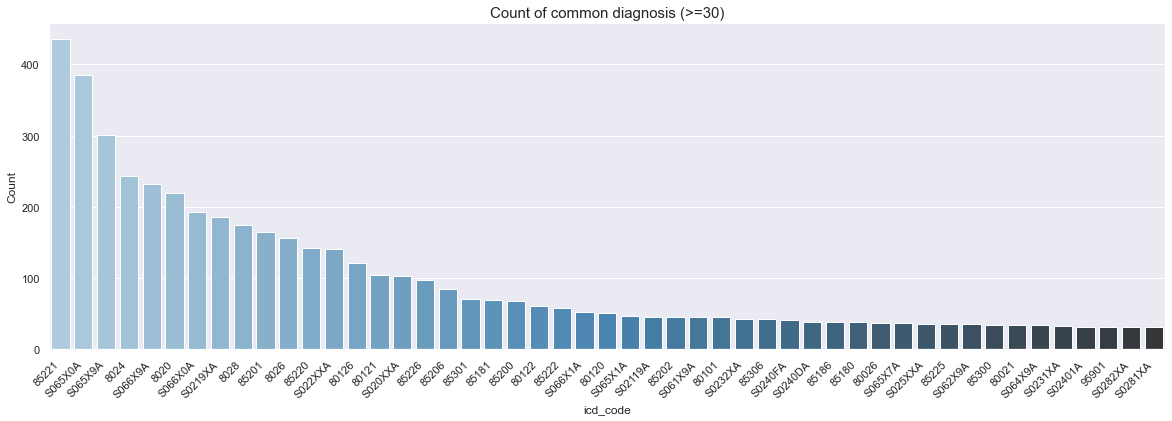

In [112]:
plt.figure(figsize=(20,6))
plt.title("Count of common diagnosis (>=30)", fontsize=15)
ax = sns.barplot(x="icd_code", y=0, data=diagnoses_counts[diagnoses_counts[0]>30], palette="Blues_d")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

## State and Action data

#### Vital Signs
|itemid|label|abbreviation|
| --- | --- | --- |
|220052|Arterial Blood Pressure mean|ABPm|
|220739|GCS - Eye Opening|Eye Opening|
|223900|GCS - Verbal Response|Verbal Response|
|223901|GCS - Motor Response|Motor Response|
|220210|Respiratory Rate|RR|
|220045|Heart Rate|HR|
|220277|O2 saturation pulseoxymetry|SpO2|
|223762|Temperature Celsius|Temperature C|


#### Actions/Treatments
|itemid|label|abbreviation|
| --- | --- | --- |
|227531|Mannitol|Mannitol|
|225161|NaCl 3% (Hypertonic Saline)|NaCl 3% (Hypertonic Saline)|

#### Lab Values (PtO2, bicarbonate not found)
|itemid|label|abbreviation|
| --- | --- | --- |
|220765|Intra Cranial Pressure|ICP|
|220621|Glucose (serum)|Glucose (serum)|
|226537|Glucose (whole blood)|Glucose (whole blood)|
|227456|Albumin|Albumin|
|220645|Sodium (serum)|Sodium (serum)|
|226534|Sodium (whole blood)|Sodium (whole blood)|
|227442|Potassium (serum)|Potassium (serum)|
|227464|Potassium (whole blood)|Potassium (whole blood)|
|220615|Creatinine (serum)|Creatinine (serum)|
|229761|Creatinine (whole blood)|Creatinine (whole blood)|
|225625|Calcium non-ionized|Calcium non-ionized|
|225667|Ionized Calcium|Ionized Calcium|
|220602|Chloride (serum)|Chloride (serum)|
|226536|Chloride (whole blood)|Chloride (whole blood)|
|220228|Hemoglobin|Hemoglobin|
|220545|Hematocrit (serum)|Hematocrit (serum)|
|226540|Hematocrit (whole blood - calc)|Hematocrit (whole blood - calc)|
|220546|WBC|WBC|
|227457|Platelet Count|Platelet Count|
|225651|Direct Bilirubin|Direct Bilirubin|
|225690|Total Bilirubin|Total Bilirubin|
|227465|Prothrombin time|PT|
|227466|PTT|PTT|
|227467|INR|INR|
|220224|Arterial O2 pressure|PO2 (Arterial)|
|220235|Arterial CO2 Pressure|PCO2 (Arterial)|




In [4]:
d_items = pd.read_csv("./mimic-iv-1.0/icu/d_items.csv.gz", compression="gzip")
# sample_icu_stays = tbi_icd_diag["stay_id"].unique()
# states = [
#     220052, 220739, 223900, 223901, 220210, 220045, 
#     220277, 223762, 220765, 220621, 226537, 227456, 
#     220645, 226534, 227442, 227464, 220615, 229761, 
#     225625, 225667, 220602, 226536, 220228, 220545, 
#     226540, 220546, 227457, 225651, 225690, 227465, 
#     227466, 227467, 220224, 220235
# ]
# actions = [227531, 225161]
states = [220765]

In [8]:
inputevents = pd.read_csv("./mimic-iv-1.0/icu/inputevents.csv.gz", compression="gzip", chunksize=50000)

action_r = pd.DataFrame()
for ies in inputevents:
    action_r = action_r.append(ies.loc[(ies['stay_id'].isin(sample_icu_stays))]) # & (ies['itemid'].isin(actions))])
items = pd.merge(action_r, d_items, on="itemid")

In [ ]:
items.value_counts(["itemid", "label"])[:40]

In [94]:
man_sal_uses = items.loc[items['itemid'].isin(actions)]
print("Sample actions data")
man_sal_uses.head()

Sample actions data


,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,...,originalamount,originalrate,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
418072,16131933,22921462,38470529,2134-10-01 16:41:00,2134-10-02 00:40:00,2134-10-01 16:41:00,225161,79.886590,ml,10.006671,...,437.958649,10.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
418073,16131933,22921462,38470529,2134-10-01 13:35:00,2134-10-01 16:41:00,2134-10-01 16:40:00,225161,62.048195,ml,20.015547,...,500.000000,20.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
418074,16131933,22921462,38470529,2134-10-01 11:00:00,2134-10-01 13:35:00,2134-10-01 16:40:00,225161,51.707000,ml,20.015614,...,51.707001,20.000067,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
418075,16131933,22921462,38470529,2134-09-30 20:07:00,2134-10-01 11:00:00,2134-10-01 16:40:00,225161,448.293163,ml,30.120481,...,500.000000,30.120480,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
418076,13386388,23146043,33072687,2171-08-15 06:35:00,2171-08-15 08:32:00,2171-08-15 06:37:00,225161,58.520342,ml,30.010431,...,500.000000,30.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN


In [119]:
print("Total number of Hypertonic Saline / Mannitol uses:")
print("----------------------------------")
print(man_sal_uses.value_counts(["itemid", "label"]))
print("\nAmong Hypertonic Saline / Mannitol uses:")
print("----------------------------------")
print(f"Unique Patients: {man_sal_uses['subject_id'].nunique()}")
print(f"Unique hospitalisations: {man_sal_uses['hadm_id'].nunique()}")
print(f"Unique ICU stays: {man_sal_uses['stay_id'].nunique()}")

Total number of Hypertonic Saline / Mannitol uses:
----------------------------------
itemid  label                      
225161  NaCl 3% (Hypertonic Saline)    1844
227531  Mannitol                        443
dtype: int64

Among Hypertonic Saline / Mannitol uses:
----------------------------------
Unique Patients: 254
Unique hospitalisations: 255
Unique ICU stays: 260


In [93]:
# save actions
man_sal_uses.to_csv("man_sal_uses.csv", index=False)

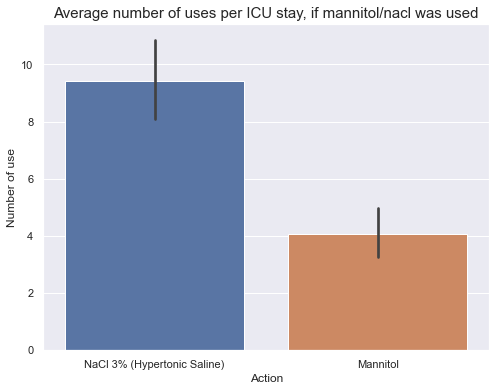

In [146]:
plt.figure(figsize=(8,6))
plt.title("Average number of uses per ICU stay, if mannitol/nacl was used", fontsize=15)
ax = sns.barplot(x="label", y=0, data=man_sal_uses.value_counts(["stay_id", "label"]).to_frame().reset_index())
plt.ylabel("Number of use")
plt.xlabel("Action")
plt.show()

In [3]:
man_sal_uses = pd.read_csv("man_sal_uses.csv")

In [4]:
man_sal_uses.head()

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,...,originalamount,originalrate,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,16131933,22921462,38470529,2134-10-01 16:41:00,2134-10-02 00:40:00,2134-10-01 16:41:00,225161,79.886590,ml,10.006671,...,437.958649,10.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
1,16131933,22921462,38470529,2134-10-01 13:35:00,2134-10-01 16:41:00,2134-10-01 16:40:00,225161,62.048195,ml,20.015547,...,500.000000,20.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
2,16131933,22921462,38470529,2134-10-01 11:00:00,2134-10-01 13:35:00,2134-10-01 16:40:00,225161,51.707000,ml,20.015614,...,51.707001,20.000067,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
3,16131933,22921462,38470529,2134-09-30 20:07:00,2134-10-01 11:00:00,2134-10-01 16:40:00,225161,448.293163,ml,30.120481,...,500.000000,30.120480,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
4,13386388,23146043,33072687,2171-08-15 06:35:00,2171-08-15 08:32:00,2171-08-15 06:37:00,225161,58.520342,ml,30.010431,...,500.000000,30.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN


In [5]:
man_sal_uses.shape

(2287, 34)

In [7]:
man_sal_uses.drop_duplicates(["stay_id", "endtime", "label"])

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,...,originalamount,originalrate,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,16131933,22921462,38470529,2134-10-01 16:41:00,2134-10-02 00:40:00,2134-10-01 16:41:00,225161,79.886590,ml,10.006671,...,437.958649,10.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
1,16131933,22921462,38470529,2134-10-01 13:35:00,2134-10-01 16:41:00,2134-10-01 16:40:00,225161,62.048195,ml,20.015547,...,500.000000,20.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
2,16131933,22921462,38470529,2134-10-01 11:00:00,2134-10-01 13:35:00,2134-10-01 16:40:00,225161,51.707000,ml,20.015614,...,51.707001,20.000067,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
3,16131933,22921462,38470529,2134-09-30 20:07:00,2134-10-01 11:00:00,2134-10-01 16:40:00,225161,448.293163,ml,30.120481,...,500.000000,30.120480,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
4,13386388,23146043,33072687,2171-08-15 06:35:00,2171-08-15 08:32:00,2171-08-15 06:37:00,225161,58.520342,ml,30.010431,...,500.000000,30.000000,NaCl 3% (Hypertonic Saline),NaCl 3% (Hypertonic Saline),inputevents,Fluids/Intake,mL,Solution,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,14014948,24610319,35794404,2189-09-17 16:31:00,2189-09-17 17:02:00,2189-09-17 16:32:00,227531,25.000000,grams,0.806452,...,25.000000,0.800000,Mannitol,Mannitol,inputevents,Medications,grams,Solution,NaN,NaN
2283,14014948,24610319,35794404,2189-09-18 10:47:00,2189-09-18 11:01:00,2189-09-18 10:47:00,227531,25.000000,grams,1.785714,...,25.000000,1.700000,Mannitol,Mannitol,inputevents,Medications,grams,Solution,NaN,NaN
2284,15895725,26898969,34784473,2111-12-05 14:25:00,2111-12-05 14:54:00,2111-12-05 15:27:00,227531,49.999999,grams,1.724138,...,50.000000,1.690000,Mannitol,Mannitol,inputevents,Medications,grams,Solution,NaN,NaN
2285,13918272,26210108,30062341,2192-11-21 17:59:00,2192-11-21 18:29:00,2192-11-21 18:04:00,227531,99.999998,grams,3.333333,...,100.000000,3.333300,Mannitol,Mannitol,inputevents,Medications,grams,Solution,NaN,NaN


In [10]:
states = [220050, 220051, 220052]

In [5]:
chartevents = pd.read_csv("./mimic-iv-1.0/icu/chartevents.csv.gz", compression="gzip", chunksize=50000)
r = pd.DataFrame()
for ces in chartevents:
    r = r.append(ces.loc[(ces['itemid'].isin(states))])

In [7]:
state_r = pd.merge(r, d_items, on="itemid")

In [14]:
state_r.to_csv("mimic_tbi_patient_icp_records.csv", index=False)

In [8]:
a = list(state_r['subject_id'].value_counts())

In [10]:
state_r['subject_id'].value_counts()

16938095    1235
12543250    1013
15545849     932
17416494     778
18729201     774
            ... 
13518155       1
13514465       1
13473209       1
14480975       1
11115356       1
Name: subject_id, Length: 1052, dtype: int64

In [11]:
i = 0
ii=0
for j in a:
    if j > 10:
        i+=1
    if j>100:
        ii+=1
print(i, ii)

981 607


In [13]:
print("Total number of state measurements:")
print("----------------------------------")
print(state_r.value_counts(["label", "itemid"]))
print("\n\nState measurements from:")
print("------------------------")
print(f"Unique Patients: {state_r['subject_id'].nunique()}")
print(f"Unique hospitalisations: {state_r['hadm_id'].nunique()}")
print(f"Unique ICU stays: {state_r['stay_id'].nunique()}")

Total number of state measurements:
----------------------------------
label                              itemid
Arterial Blood Pressure mean       220052    126721
Arterial Blood Pressure systolic   220050    126488
Arterial Blood Pressure diastolic  220051    126466
dtype: int64


State measurements from:
------------------------
Unique Patients: 1174
Unique hospitalisations: 1191
Unique ICU stays: 1246


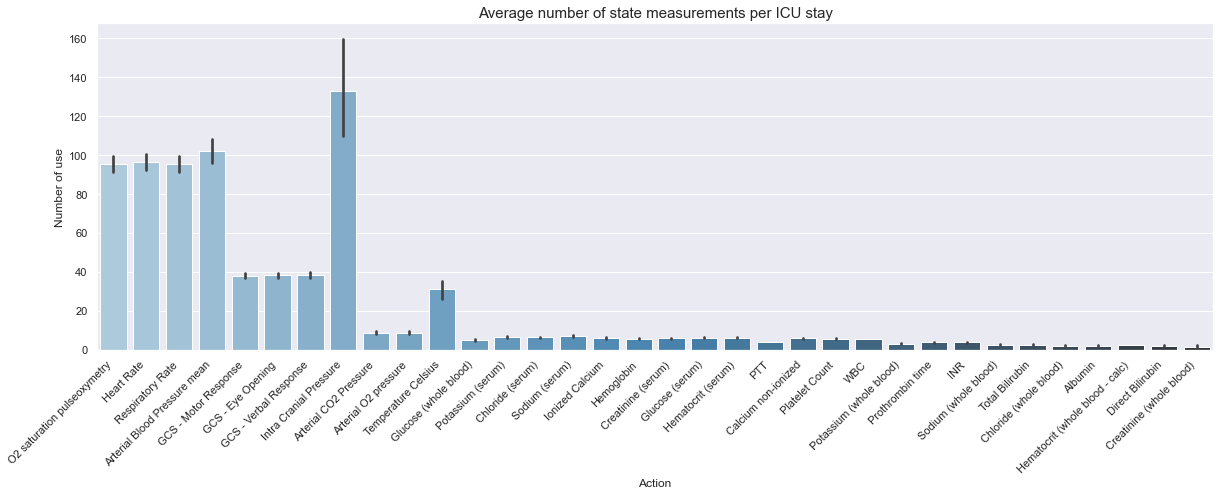

In [144]:
plt.figure(figsize=(20,6))
plt.title("Average number of state measurements per ICU stay", fontsize=15)
ax = sns.barplot(x="label", y=0, data=state_r.value_counts(["stay_id", "label"]).to_frame().reset_index(), palette="Blues_d")
plt.ylabel("Number of use")
plt.xlabel("Action")
plt.xticks(rotation=45, ha='right')
plt.show()

In [125]:
# save states
state_r.to_csv("tbi_icu_states.csv", index=False)

## All ICU patients who had been given mannitol / hypertonic saline

In [129]:
inputevents = pd.read_csv("./mimic-iv-1.0/icu/inputevents.csv.gz", compression="gzip", chunksize=50000)

all_ms = pd.DataFrame()
for ies in inputevents:
    all_ms = all_ms.append(ies.loc[(ies['itemid'].isin(actions))])
all_ms = pd.merge(all_ms, d_items, on="itemid")

In [135]:
all_ms = pd.merge(all_ms, diagnoses_icd, on="hadm_id")

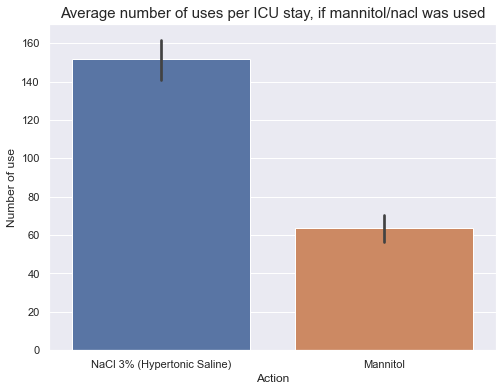

In [145]:
plt.figure(figsize=(8,6))
plt.title("Average number of uses per ICU stay, if mannitol/nacl was used", fontsize=15)
ax = sns.barplot(x="label", y=0, data=all_ms.value_counts(["stay_id", "label"]).to_frame().reset_index())
plt.ylabel("Number of use")
plt.xlabel("Action")
plt.show()

In [140]:
all_ms.value_counts(["stay_id", "label"])

stay_id   label                      
32866003  NaCl 3% (Hypertonic Saline)    1368
30986145  NaCl 3% (Hypertonic Saline)    1320
34130756  NaCl 3% (Hypertonic Saline)    1302
31365006  NaCl 3% (Hypertonic Saline)    1225
37224074  NaCl 3% (Hypertonic Saline)    1155
                                         ... 
31138035  NaCl 3% (Hypertonic Saline)       4
39567319  Mannitol                          4
35445060  Mannitol                          4
38405668  Mannitol                          4
38718180  Mannitol                          3
Length: 1788, dtype: int64

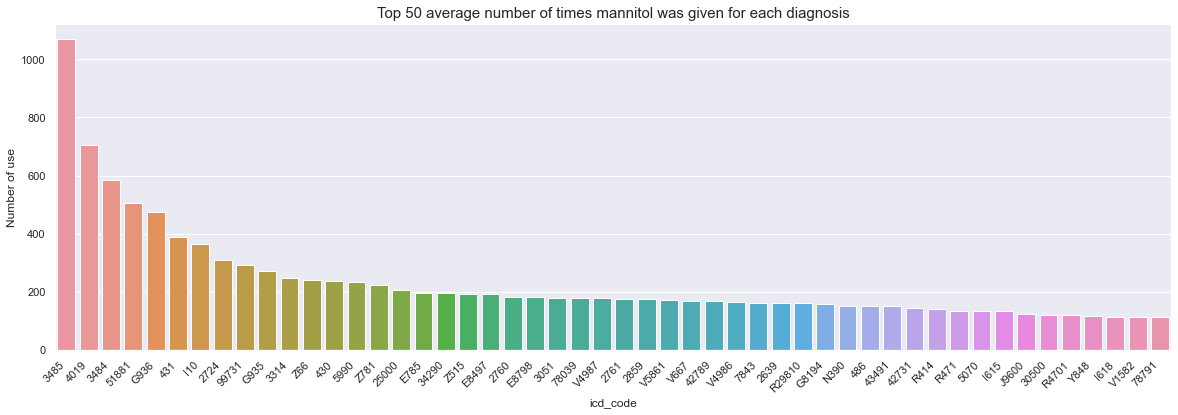

In [157]:
plt.figure(figsize=(20,6))
plt.title("Top 50 average number of times mannitol was given for each diagnosis", fontsize=15)
ax = sns.barplot(x="icd_code", y=0, data=all_ms[all_ms["label"]=="Mannitol"].value_counts(["icd_code"])[:50].to_frame().reset_index())
plt.ylabel("Number of use")
plt.xticks(rotation=45, ha='right')
plt.show()

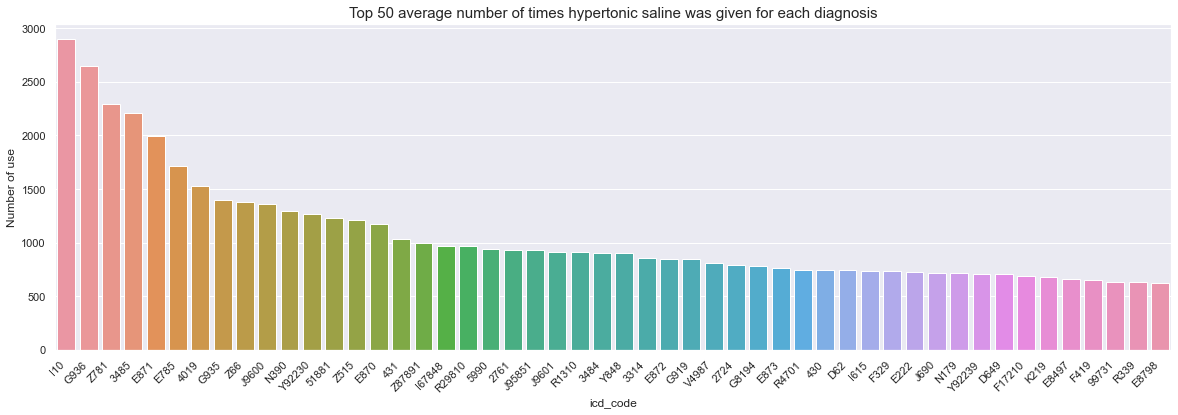

In [156]:
plt.figure(figsize=(20,6))
plt.title("Top 50 average number of times hypertonic saline was given for each diagnosis", fontsize=15)
ax = sns.barplot(x="icd_code", y=0, data=all_ms[all_ms["label"]=="NaCl 3% (Hypertonic Saline)"].value_counts(["icd_code"])[:50].to_frame().reset_index())
plt.ylabel("Number of use")
plt.xticks(rotation=45, ha='right')
plt.show()

In [158]:
all_ms.to_csv("all_ms.csv", index=False)